In [213]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

In [214]:
priors = dict(tau0=2.0,tau1=2.0,sigma_alpha=10.0,sigma_beta=1.0)

In [215]:
# read in data
df = pd.read_csv('insurance.csv')
insurance_data = df[['bmi', 'age', 'children']].values.astype(float)
charges = df['charges'].values.astype(float)
i_mean, i_std = insurance_data.mean(axis=0), insurance_data.std(axis=0)
D = (insurance_data - i_mean) / i_std

In [216]:
#split data to training and test
train_percent = 0.8 #training 80%
indices = np.random.permutation(len(D))
split = int(train_percent * len(indices))
train_index = indices[:split]
test_index = indices[split:]
D_train, D_test, C_train, C_test = D[train_index], D[test_index], charges[train_index], charges[test_index]

In [217]:
code = '''
data {
  int<lower=1> N;                 // number of training cases
  int<lower=1> K;                 // number of predictors
  matrix[N, K] X;                 // standardized predictors
  vector[N] y;                    // insurance charges
  real<lower=0> tau0;             // Inv‑Gamma prior shape
  real<lower=0> tau1;             // Inv‑Gamma prior scale
  real<lower=0> sigma_alpha;      // intercept prior SD
  real<lower=0> sigma_beta;       // slope prior SD
}
parameters {
  real alpha;                     // intercept
  vector[K] beta;                 // slopes
  real<lower=0> sigma;            // noise SD
}
model {
  sigma ~ inv_gamma(tau0, tau1);
  alpha ~ normal(0, sigma_alpha);
  beta ~ normal(0, sigma_beta);
  y ~ normal(alpha + X * beta, sigma);
}

'''

In [218]:
data = {
    'N': D_train.shape[0],
    'K': D_train.shape[1],
    'X': D_train,
    'y': C_train,
    **priors
}

In [219]:
sm = stan.build(program_code=code, data=data)
fit = sm.sample(num_chains=4, num_samples=1000)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:  25% (2003/8000)
Sampling:  50% (4002/8000)
Sampling:  75% (6001/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000254 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.54 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000408 seconds
  1000 transitions using 10 leapfrog steps per transition would take 4.08 seconds.
  Adjust your expectations accordingly

In [220]:
az_fit = az.from_pystan(posterior=fit)
print(az.summary(az_fit, var_names=['alpha', 'beta', 'sigma']))

              mean       sd     hdi_3%    hdi_97%  mcse_mean  mcse_sd  \
alpha        4.351    9.992    -13.975     23.375      0.135    0.146   
beta[0]      0.019    1.007     -1.902      1.891      0.014    0.016   
beta[1]     -0.009    1.005     -1.957      1.853      0.014    0.016   
beta[2]     -0.000    0.973     -1.857      1.828      0.014    0.016   
sigma    18047.183  385.810  17305.638  18744.294      5.549    3.924   

         ess_bulk  ess_tail  r_hat  
alpha      5443.0    3319.0    1.0  
beta[0]    4980.0    2936.0    1.0  
beta[1]    5370.0    3039.0    1.0  
beta[2]    4845.0    3137.0    1.0  
sigma      4816.0    2993.0    1.0  


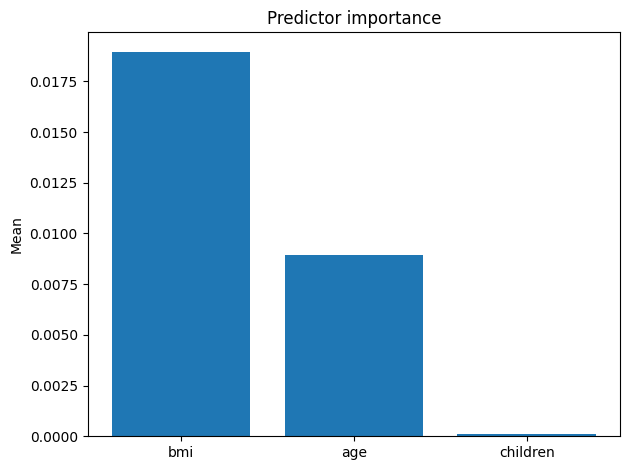

In [221]:
beta_draws = fit["beta"]
beta_mean  = np.abs(beta_draws.mean(axis=1))
plt.bar(['bmi', 'age', 'children'], beta_mean)
plt.ylabel('Mean')
plt.title('Predictor importance')
plt.tight_layout()
plt.show()

The best predictor of insurance charges is BMI.